**Exercise 6.4**

MNIST with fully connected networks and grid/random search

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data.

In [28]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras import regularizers


from tabulate import tabulate

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_valid = x_test[8000:]
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# Hint: convert integer RGB values (0-255) to float values (0-1)
#x_train = x_train.astype('float32')/255
#x_valid = x_valid.astype('float32')/255
#x_test = x_test.astype('float32')/255
#y_test = y_test.astype('float32')/255

In [3]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [4]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc.
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [5]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [17]:
# define model here
model = Sequential([
    Dense(128, input_shape=(784,), activation='relu'),
    Dropout(0.1),
    Dense(10),
    Activation('softmax')])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               100480    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
model.compile(
    loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
    optimizer= keras.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and with regularization applied,
# while the validation metrics are calculated at the end of each epoch.
# This callback calculates the training metrics the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),

    batch_size= 64, #first try I picked 64
    epochs=10,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
    )

Epoch 1/10
938/938 [==============================] - 10s 9ms/step - loss: 2.7469 - accuracy: 0.8139 - val_loss: 0.3737 - val_accuracy: 0.8935 - train_loss: 0.4669 - train_acc: 0.8793
Epoch 2/10
938/938 [==============================] - 8s 9ms/step - loss: 0.4757 - accuracy: 0.8765 - val_loss: 0.2665 - val_accuracy: 0.9345 - train_loss: 0.2920 - train_acc: 0.9193
Epoch 3/10
938/938 [==============================] - 8s 9ms/step - loss: 0.3485 - accuracy: 0.9055 - val_loss: 0.2481 - val_accuracy: 0.9340 - train_loss: 0.2538 - train_acc: 0.9294
Epoch 4/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2996 - accuracy: 0.9172 - val_loss: 0.1681 - val_accuracy: 0.9510 - train_loss: 0.1934 - train_acc: 0.9448
Epoch 5/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2686 - accuracy: 0.9249 - val_loss: 0.1974 - val_accuracy: 0.9595 - train_loss: 0.1775 - train_acc: 0.9510
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2550 - a

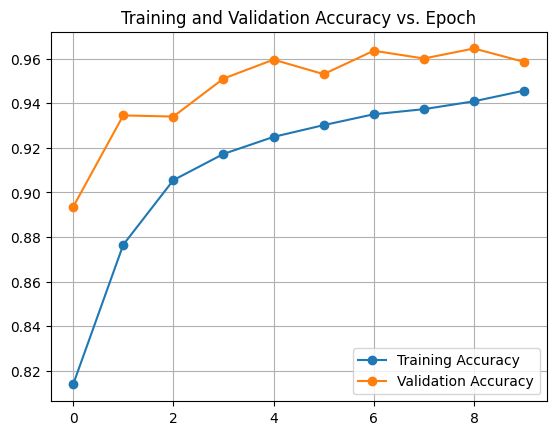

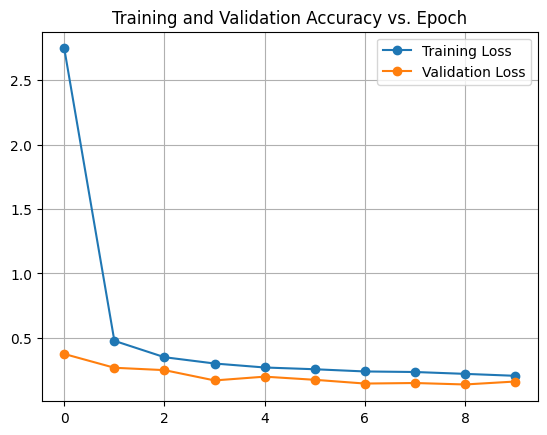

250/250 [==============================] - 1s 3ms/step - loss: 0.2205 - accuracy: 0.9510
Test Accuracy:  95.09999752044678


In [19]:
# load best model
model.load_weights(f"best_model_{model.name}.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
# add plots below

# Plot training and validation accuracy
plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(history['epoch'], history['loss'], label='Training Loss', marker='o')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate the model on the test dataset
final_test_accuracy = model.evaluate(x_test, y_test_onehot)[-1]*100
print(f"Test Accuracy: ", final_test_accuracy)

In [20]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    ["Train", *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Validation", *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])*100 ],
    ["Test", *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128), (1-model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1])*100 ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |     Loss |   Accuracy |   Test error rate [%] |
|------------+----------+------------+-----------------------|
| Train      | 0.13149  |   0.962083 |               3.79167 |
| Validation | 0.136645 |   0.9645   |               3.55    |
| Test       | 0.220511 |   0.951    |               4.9     |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [21]:
#@title
def plot_image(X, ax=None):
    """Plot an image X.

    Args:
        X (2D array): image, grayscale or RGB
        ax (None, optional): Description
    """
    if ax is None:
        ax = plt.gca()

    if (X.ndim == 2) or (X.shape[-1] == 1):
        ax.imshow(X.astype('uint8'), origin='upper', cmap=plt.cm.Greys)
    else:
        ax.imshow(X.astype('uint8'), origin='upper')

    ax.set(xticks=[], yticks=[])

def plot_prediction(Yp, X, y, classes=None, top_n=False):
    """Plot an image along with all or the top_n predictions.

    Args:
        Yp (1D array): predicted probabilities for each class
        X (2D array): image
        y (integer): true class label
        classes (1D array, optional): class names
        top_n (int, optional): number of top predictions to show
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)
    plot_image(X, ax1)

    if top_n:
        n = top_n
        s = np.argsort(Yp)[-top_n:]
    else:
        n = len(Yp)
        s = np.arange(n)[::-1]

    patches = ax2.barh(np.arange(n), Yp[s], align='center')
    ax2.set(xlim=(0, 1), xlabel='Probability', yticks=[])

    for iy, patch in zip(s, patches):
        if iy == y:
            patch.set_facecolor('C1')  # color correct patch

    if classes is None:
        classes = np.arange(0, np.size(Yp))

    for i in range(n):
        ax2.text(0.05, i, classes[s][i], ha='left', va='center')

    plt.show()

def plot_confusion(yp, y, classes=None, fname=None):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    if classes is None:
        n = max(max(yp), max(y)) + 1
        classes = np.arange(n)
    else:
        n = len(classes)

    bins = np.linspace(-0.5, n - 0.5, n + 1)
    C = np.histogram2d(y, yp, bins=bins)[0]
    C = C / np.sum(C, axis=0) * 100

    fig = plt.figure(figsize=(8, 8))
    plt.imshow(C, interpolation='nearest', vmin=0, vmax=100, cmap=plt.cm.YlGnBu)
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label('Frequency %')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(n), classes, rotation='vertical')
    plt.yticks(range(n), classes)
    for x in range(n):
        for y in range(n):
            if np.isnan(C[x, y]):
                continue
            color = 'white' if x == y else 'black'
            plt.annotate('%.1f' % (C[x, y]), xy=(y, x), color=color, ha='center', va='center')

    plt.show()

63/63 [==============================] - 0s 3ms/step


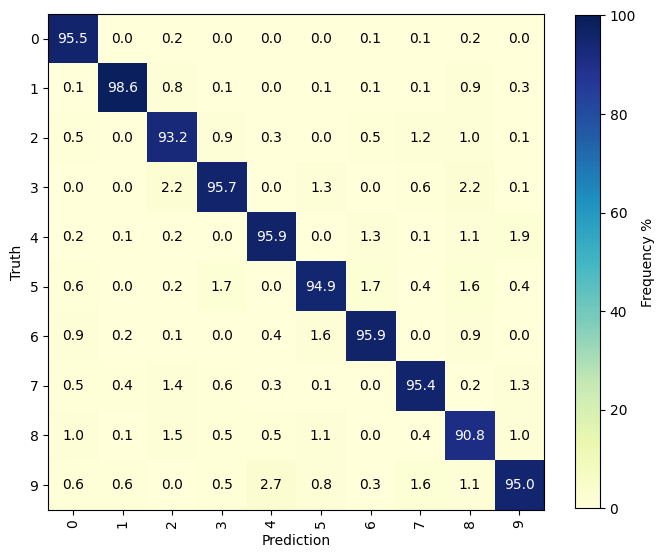

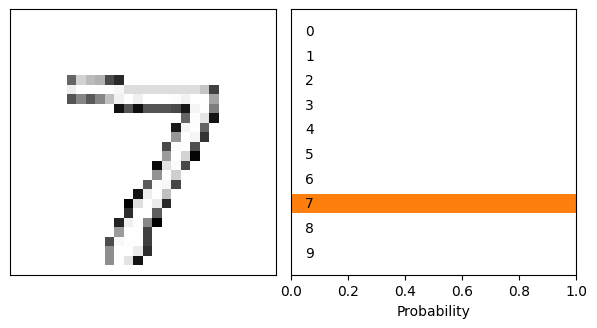

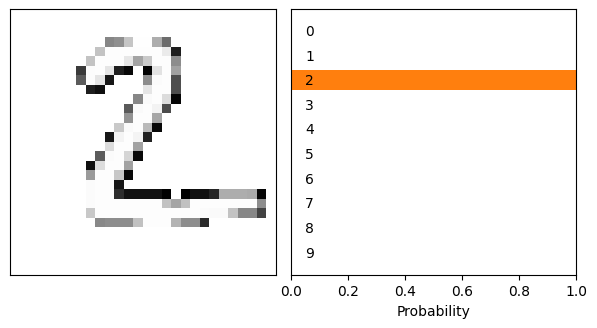

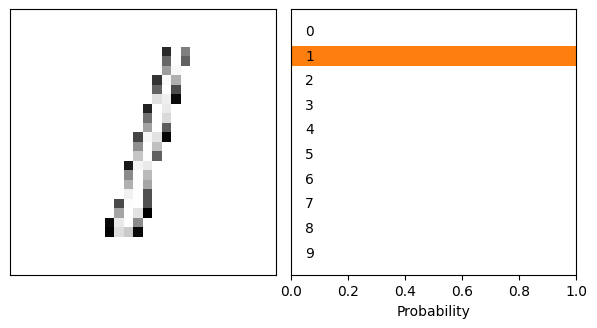

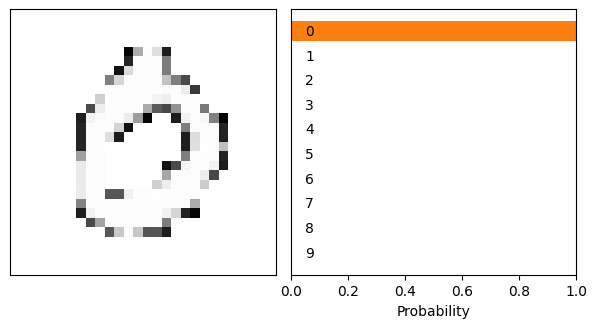

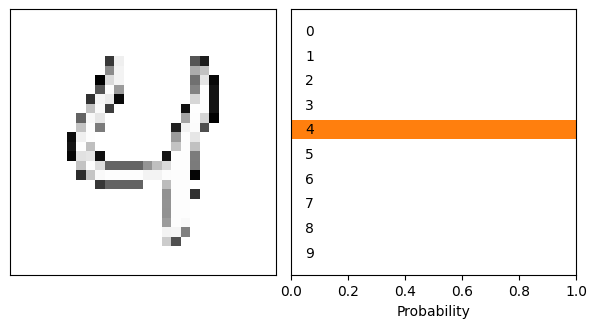

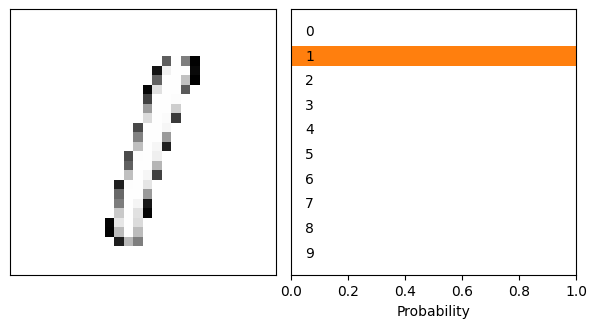

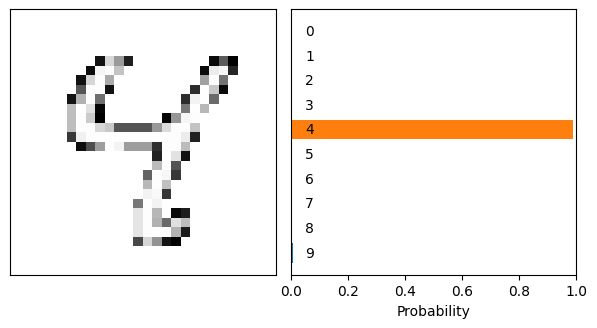

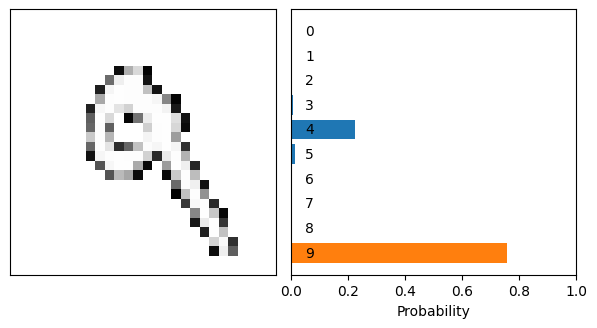

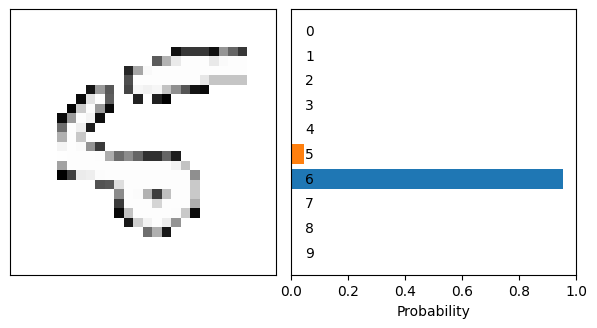

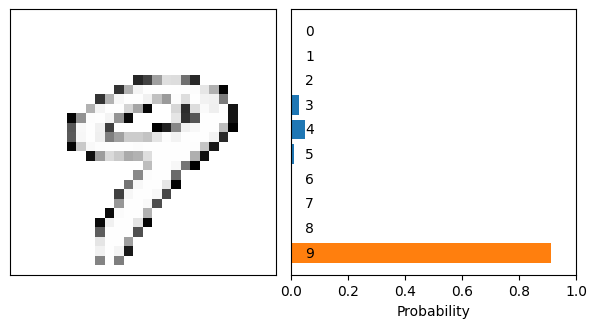

In [22]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

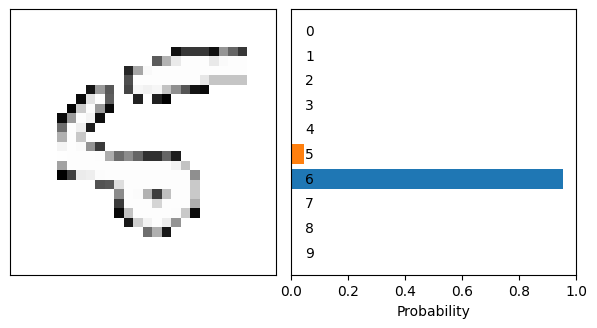

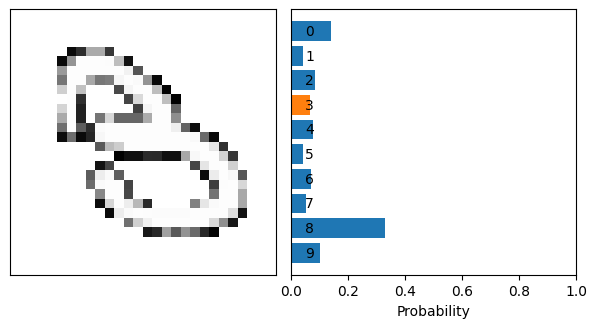

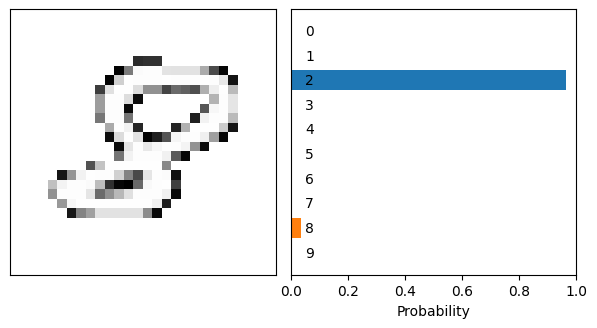

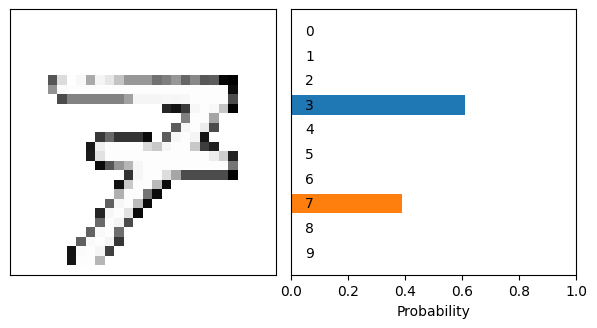

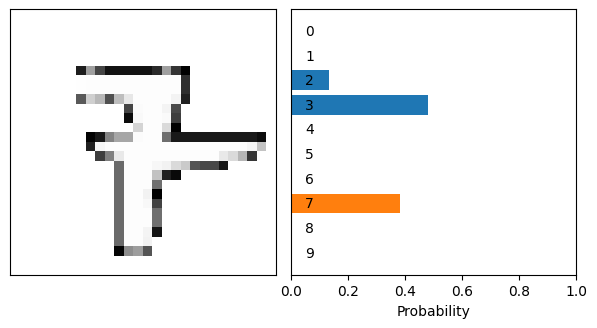

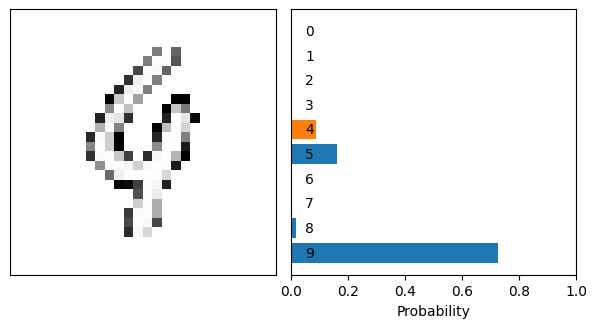

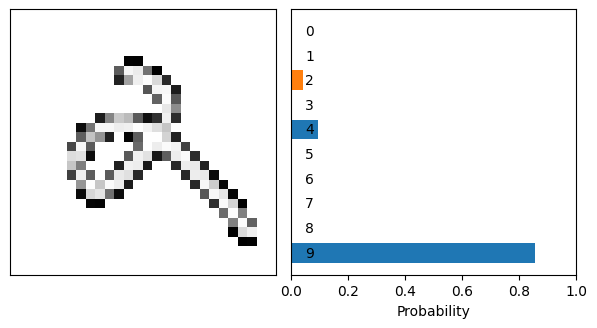

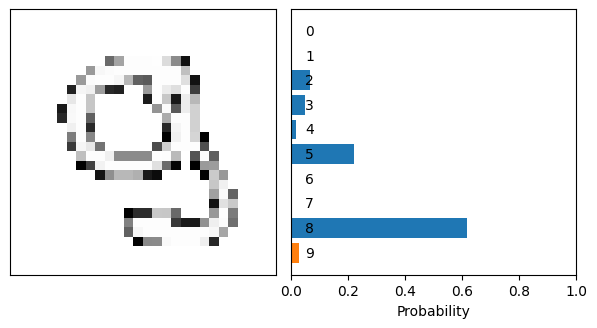

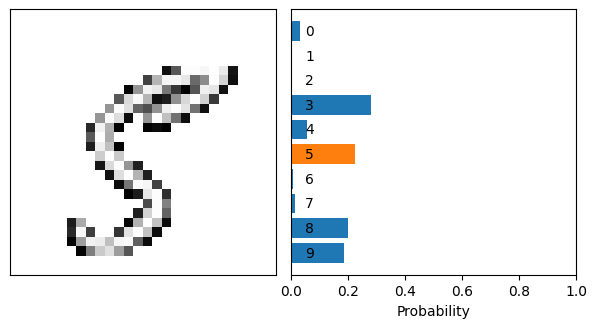

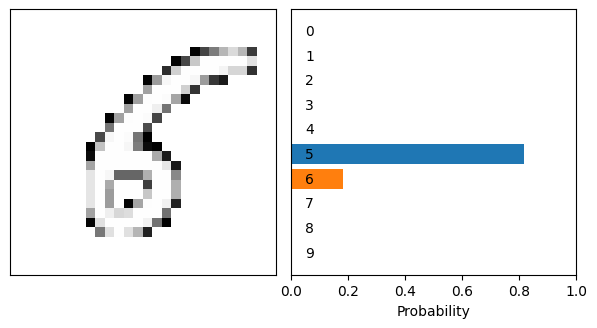

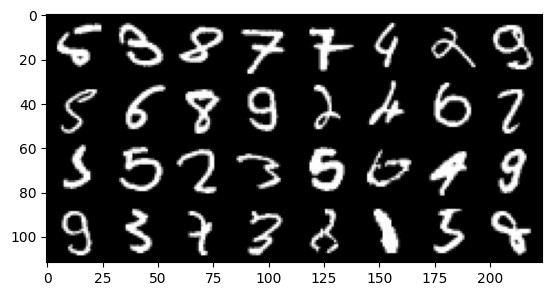

In [23]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below.



In [30]:
dropout_values = [0, 0.2, 0.4, 0.6]
n_neurons_values = [64, 128, 256, 512]

results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    model = tf.keras.models.Sequential([
        Dense(n_neurons, input_shape=(784,), activation = 'relu'),
        Dropout(drop),
        Dense(10),
        Activation('softmax')])  # softmax actication to transform output into probabiliites

    model.compile(
        loss='categorical_crossentropy',  # the recommended loss for a classification task is 'categorical_crossentropy' (see lecture for details)
        optimizer='rmsprop',
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=32,
        epochs=10,
        verbose=0
        )
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


dropout = 0.00, 64 neurons -> accuracy 0.942, error rate = 5.8%
dropout = 0.00, 128 neurons -> accuracy 0.952, error rate = 4.8%
dropout = 0.00, 256 neurons -> accuracy 0.965, error rate = 3.5%
dropout = 0.00, 512 neurons -> accuracy 0.965, error rate = 3.5%
dropout = 0.20, 64 neurons -> accuracy 0.918, error rate = 8.2%
dropout = 0.20, 128 neurons -> accuracy 0.942, error rate = 5.8%
dropout = 0.20, 256 neurons -> accuracy 0.959, error rate = 4.1%
dropout = 0.20, 512 neurons -> accuracy 0.967, error rate = 3.3%
dropout = 0.40, 64 neurons -> accuracy 0.880, error rate = 12.0%
dropout = 0.40, 128 neurons -> accuracy 0.910, error rate = 9.0%
dropout = 0.40, 256 neurons -> accuracy 0.948, error rate = 5.2%
dropout = 0.40, 512 neurons -> accuracy 0.961, error rate = 3.9%
dropout = 0.60, 64 neurons -> accuracy 0.846, error rate = 15.4%
dropout = 0.60, 128 neurons -> accuracy 0.877, error rate = 12.3%
dropout = 0.60, 256 neurons -> accuracy 0.929, error rate = 7.1%
dropout = 0.60, 512 neuron

**Random seach**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below.




In [32]:
N = 20 # number of trials
search = {
'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
'learn_rate': np.random.choice([0.0001,0.001, 0.01, 0.1, 1],N),
'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
'val_acc': np.zeros(N)
}

for i in tqdm(range(N)):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      Dense(search['num_neurons'][i], input_shape=(784,), activation = search['activation'][i]),
                      Dropout(search['dropout'][i]),
                      Dense(10, activation='softmax')])

  opt_i = tf.keras.optimizers.Adam(learning_rate=search['learn_rate'][i])

  model.compile(loss='categorical_crossentropy',
  optimizer=opt_i,
  metrics=['accuracy'])
  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=search['batch_size'][i],
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")


  5%|▌         | 1/20 [03:31<1:06:56, 211.40s/it]

iteration 0:
	batch_size: 16
	num_neurons: 512
	learn_rate: 0.001
	activation: elu
	dropout: 0.1
	val_acc: 0.9461249709129333
	-> accuracy 0.946, error rate = 5.4%


 10%|█         | 2/20 [03:37<27:13, 90.77s/it]   

iteration 1:
	batch_size: 256
	num_neurons: 8
	learn_rate: 0.001
	activation: sigmoid
	dropout: 0.2
	val_acc: 0.8289999961853027
	-> accuracy 0.829, error rate = 17.1%


 15%|█▌        | 3/20 [05:25<27:54, 98.48s/it]

iteration 2:
	batch_size: 16
	num_neurons: 256
	learn_rate: 0.1
	activation: elu
	dropout: 0.2
	val_acc: 0.09662500023841858
	-> accuracy 0.097, error rate = 90.3%


 20%|██        | 4/20 [05:59<19:29, 73.10s/it]

iteration 3:
	batch_size: 64
	num_neurons: 256
	learn_rate: 0.1
	activation: tanh
	dropout: 0.2
	val_acc: 0.40575000643730164
	-> accuracy 0.406, error rate = 59.4%


 25%|██▌       | 5/20 [13:04<49:58, 199.87s/it]

iteration 4:
	batch_size: 16
	num_neurons: 8
	learn_rate: 1.0
	activation: relu
	dropout: 0.5
	val_acc: 0.09849999845027924
	-> accuracy 0.098, error rate = 90.2%


 30%|███       | 6/20 [13:19<31:58, 137.02s/it]

iteration 5:
	batch_size: 256
	num_neurons: 256
	learn_rate: 0.1
	activation: tanh
	dropout: 0.0
	val_acc: 0.5612499713897705
	-> accuracy 0.561, error rate = 43.9%


 35%|███▌      | 7/20 [13:27<20:33, 94.86s/it] 

iteration 6:
	batch_size: 256
	num_neurons: 8
	learn_rate: 0.1
	activation: sigmoid
	dropout: 0.3
	val_acc: 0.18700000643730164
	-> accuracy 0.187, error rate = 81.3%


 40%|████      | 8/20 [13:45<14:06, 70.55s/it]

iteration 7:
	batch_size: 128
	num_neurons: 128
	learn_rate: 0.1
	activation: elu
	dropout: 0.1
	val_acc: 0.10237500071525574
	-> accuracy 0.102, error rate = 89.8%


 45%|████▌     | 9/20 [14:08<10:10, 55.53s/it]

iteration 8:
	batch_size: 64
	num_neurons: 8
	learn_rate: 0.1
	activation: relu
	dropout: 0.2
	val_acc: 0.11312499642372131
	-> accuracy 0.113, error rate = 88.7%


 50%|█████     | 10/20 [18:11<18:55, 113.55s/it]

iteration 9:
	batch_size: 16
	num_neurons: 512
	learn_rate: 0.0001
	activation: elu
	dropout: 0.5
	val_acc: 0.9673749804496765
	-> accuracy 0.967, error rate = 3.3%


 55%|█████▌    | 11/20 [22:22<23:18, 155.39s/it]

iteration 10:
	batch_size: 16
	num_neurons: 512
	learn_rate: 1.0
	activation: relu
	dropout: 0.0
	val_acc: 0.11474999785423279
	-> accuracy 0.115, error rate = 88.5%


 60%|██████    | 12/20 [23:21<16:48, 126.12s/it]

iteration 11:
	batch_size: 32
	num_neurons: 128
	learn_rate: 0.0001
	activation: relu
	dropout: 0.5
	val_acc: 0.9121249914169312
	-> accuracy 0.912, error rate = 8.8%


 65%|██████▌   | 13/20 [24:45<13:15, 113.58s/it]

iteration 12:
	batch_size: 16
	num_neurons: 32
	learn_rate: 0.1
	activation: tanh
	dropout: 0.1
	val_acc: 0.10225000232458115
	-> accuracy 0.102, error rate = 89.8%


 70%|███████   | 14/20 [24:53<08:10, 81.70s/it] 

iteration 13:
	batch_size: 256
	num_neurons: 8
	learn_rate: 0.1
	activation: relu
	dropout: 0.0
	val_acc: 0.1016250029206276
	-> accuracy 0.102, error rate = 89.8%


 75%|███████▌  | 15/20 [26:11<06:41, 80.40s/it]

iteration 14:
	batch_size: 32
	num_neurons: 256
	learn_rate: 0.001
	activation: sigmoid
	dropout: 0.6
	val_acc: 0.9281250238418579
	-> accuracy 0.928, error rate = 7.2%


 80%|████████  | 16/20 [26:41<04:20, 65.24s/it]

iteration 15:
	batch_size: 256
	num_neurons: 512
	learn_rate: 0.01
	activation: sigmoid
	dropout: 0.5
	val_acc: 0.8708750009536743
	-> accuracy 0.871, error rate = 12.9%


 85%|████████▌ | 17/20 [26:57<02:31, 50.40s/it]

iteration 16:
	batch_size: 128
	num_neurons: 32
	learn_rate: 0.0001
	activation: elu
	dropout: 0.5
	val_acc: 0.5431249737739563
	-> accuracy 0.543, error rate = 45.7%


 90%|█████████ | 18/20 [27:55<01:45, 52.66s/it]

iteration 17:
	batch_size: 32
	num_neurons: 128
	learn_rate: 0.01
	activation: sigmoid
	dropout: 0.1
	val_acc: 0.8206250071525574
	-> accuracy 0.821, error rate = 17.9%


 95%|█████████▌| 19/20 [28:03<00:39, 39.22s/it]

iteration 18:
	batch_size: 256
	num_neurons: 8
	learn_rate: 1.0
	activation: relu
	dropout: 0.2
	val_acc: 0.10037499666213989
	-> accuracy 0.100, error rate = 90.0%


100%|██████████| 20/20 [28:47<00:00, 86.38s/it]

iteration 19:
	batch_size: 128
	num_neurons: 512
	learn_rate: 0.001
	activation: sigmoid
	dropout: 0.2
	val_acc: 0.9427499771118164
	-> accuracy 0.943, error rate = 5.7%


General Comment

From this assingment we can conclude that the selection of the hyperparameters is crucial for the success of our training. In the final two subtasks we can see that the accuarcy of out model differs greatly depending on the hyperparameters. 

However, we also see that many different combinations of hyperparameters can yield similarly good results. We can thereby conclude that when training a deep neural network, one should try a few different values and combinations of hyperparameters.